# **Trabajo Práctico N°2 - Aprendizaje Automático 1**
**Integrantes**:

Dito, Daniela

Flaibani, Marcela

López Crespo, facundo

## Librerías

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_predict
from scipy.stats import mode

#import plotly.express as px

import warnings
warnings.filterwarnings('ignore')



## 1. Análisis descriptivo 

### Lectura y primeras manipulaciones del DataSet 

In [6]:
df = pd.read_csv('weatherAUS.csv')
df.shape

(145460, 23)

In [7]:
# Elección aleatoria de 10 ciudades
ciud = pd.Series(df['Location'].unique())
ciud_10 = ciud.sample(n=10,random_state=1)
ciud_10

27        Dartmoor
34       Nuriootpa
39    PerthAirport
48           Uluru
2            Cobar
3     CoffsHarbour
42         Walpole
29          Cairns
45    AliceSprings
30       GoldCoast
dtype: object

In [8]:
# Filtro del df según ciudades seleccionadas y luego descarto la columna ciudad 
df_weather = df[df['Location'].isin(ciud_10)]
df_weather = df_weather.drop('Location',axis=1)

In [9]:
df_weather.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

El dataset a analizar se compone de observaciones diarias de las siguientes variables meteorológicas:
* **Temperatura**: [MinTemp, MaxTemp, Temp9am, Temp3pm]. Variables cuantitativas continuas. 

* **Lluvia**: 

    [Rainfall]. Variable cuantitavia continua.

    [RainToday, RainTomorrow]. Variable cualitativa nominal.
* **Evaporización**: [Evaporation]. Variable cuantitavia .

* **Luminosidad**: [Sunshine]. Variable cuantitativa. 
* **Viento**: 

    [WindSpeed9am, WindSpeed3pm, WindGustSpeed]. Variables cuantitativas continuas.

    [WindGustDir, WindDir9am, WindDir3pm]. Variables cualitativas nominales
* **Humedad**: [Humidity9am, Humidity3pm]. Variables cuantitativas continuas. 

* **Presión**: [Pressure9am, Pressure3pm]. Variables cuantitativas continuas.  
* **Nubosidad**: [Cloud9am, Cloud3pm]. Variables cuantitativas continuas.  


In [10]:
# Elimino las observaciones cuya variable target tiene valor nulo
df_weather = df_weather.dropna(subset=['RainTomorrow'])

In [11]:
# En relación al tiempo se utilizan las features Date(cuantitativa) y Month(cualitativa)
df_weather['Date']=pd.to_datetime(df_weather['Date'],format='mixed')
df_weather['Month'] = df_weather['Date'].dt.month
meses = ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic']
month_dict = {}
for i,mes in enumerate(meses):
    month_dict[i+1] = mes
df_weather['Month'] = df_weather['Month'].map(month_dict)    

In [12]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28234 entries, 6049 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           28234 non-null  datetime64[ns]
 1   MinTemp        28193 non-null  float64       
 2   MaxTemp        28211 non-null  float64       
 3   Rainfall       28049 non-null  float64       
 4   Evaporation    18330 non-null  float64       
 5   Sunshine       15473 non-null  float64       
 6   WindGustDir    27545 non-null  object        
 7   WindGustSpeed  27591 non-null  float64       
 8   WindDir9am     26591 non-null  object        
 9   WindDir3pm     27770 non-null  object        
 10  WindSpeed9am   27878 non-null  float64       
 11  WindSpeed3pm   27886 non-null  float64       
 12  Humidity9am    27887 non-null  float64       
 13  Humidity3pm    27881 non-null  float64       
 14  Pressure9am    27926 non-null  float64       
 15  Pressure3pm    27926

In [13]:
df_weather.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
6049,2009-01-01,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,ene
6050,2009-01-02,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,ene
6051,2009-01-03,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,ene
6052,2009-01-04,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,ene
6053,2009-01-05,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,ene


### División del DataSet: Train - Test

In [14]:
# División del DF entre train y test VER STRATIFY
X = df_weather.drop(columns='RainTomorrow')
y = df_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22587, 22), (5647, 22), (22587,), (5647,))

In [15]:
#Armo los data frame de entrenamiento y de testeo
df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([y_test,y_test],axis=1)

In [16]:
# Filtro aquellos registros de entrenamiento que no tienen más de 3 features nulas 
# es lo que permite el límite del 5% para eliminar registros del conjunto de entrenamiento
idxs_registros_aceptables = df_train.dropna(thresh=18).index
X_train = X_train.loc[idxs_registros_aceptables]
y_train = y_train.loc[idxs_registros_aceptables]
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [17]:
X_train.shape

(22047, 22)

In [18]:
# Solamente se describen variables cuantitativas
round(X_train.describe(),1)

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,22047,22027.0,22034.0,22023.0,14629.0,12389.0,21881.0,22033.0,22036.0,21847.0,21847.0,22025.0,22031.0,13201.0,12817.0,22044.0,22046.0
mean,2013-04-25 05:29:54.366580480,13.6,25.0,2.6,5.8,8.0,40.1,15.3,19.5,63.6,49.4,1017.5,1014.9,3.9,4.0,19.0,23.5
min,2008-12-01 00:00:00,-5.2,7.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,1.0,982.0,985.1,0.0,0.0,-0.3,5.3
25%,2011-02-08 12:00:00,8.7,19.8,0.0,2.8,5.3,31.0,9.0,13.0,50.0,30.0,1013.0,1010.3,1.0,1.0,13.9,18.4
50%,2013-06-18 00:00:00,13.4,24.9,0.0,5.0,9.0,39.0,15.0,19.0,65.0,52.0,1017.4,1014.8,4.0,4.0,19.0,23.2
75%,2015-06-28 00:00:00,18.8,29.9,0.6,8.0,10.9,48.0,20.0,24.0,80.0,66.0,1021.9,1019.3,7.0,7.0,24.2,28.1
max,2017-06-25 00:00:00,31.0,46.6,371.0,86.2,14.3,113.0,72.0,61.0,100.0,100.0,1040.4,1037.7,8.0,8.0,39.4,45.2
std,NaN,6.4,7.0,10.3,4.3,3.7,11.9,8.2,8.1,22.1,23.1,6.6,6.6,2.9,2.8,6.6,6.8


In [19]:
# Obtengo el porcentaje de valores faltantes por feature
round(X_train.isna().sum().sort_values(ascending=False) / len(X_train) * 100, 0) 

Sunshine         44.0
Cloud3pm         42.0
Cloud9am         40.0
Evaporation      34.0
WindDir9am        4.0
Humidity3pm       1.0
Humidity9am       1.0
WindGustDir       1.0
WindGustSpeed     1.0
WindDir3pm        0.0
RainToday         0.0
Rainfall          0.0
Pressure9am       0.0
MinTemp           0.0
Pressure3pm       0.0
WindSpeed9am      0.0
MaxTemp           0.0
WindSpeed3pm      0.0
Temp9am           0.0
Temp3pm           0.0
Date              0.0
Month             0.0
dtype: float64

In [20]:
# Interesa distinguir las features cuantitativas de aquellas features cualitativas
features_cuanti = list(X_train.describe().columns)
features_cuali = [feature for feature in X_train.columns if feature not in features_cuanti]
print(f'Features cuantitativas:\n')
[print(feature_cuanti) for feature_cuanti in features_cuanti]
print(f'Features cualitativas:\n')
[print(feature_cuali) for feature_cuali in features_cuali]
# Elimino feature date de cuanti para que después no traiga problemas
features_cuanti.remove('Date')

Features cuantitativas:

Date
MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp9am
Temp3pm
Features cualitativas:

WindGustDir
WindDir9am
WindDir3pm
RainToday
Month


In [21]:
# Las variables cualitativas que presenta el df son de tipo nominal, pues no se pueden ordenar jerárquicamente
[print(f"{feature_cuali}:\n{X_train[feature_cuali].unique()}") for feature_cuali in features_cuali]
    

WindGustDir:
['ESE' 'WSW' 'SSW' 'ENE' 'E' 'SE' 'S' 'WNW' 'W' 'SW' 'N' 'NW' 'SSE' 'NE'
 'NNW' 'NNE' nan]
WindDir9am:
['E' 'S' 'N' 'ESE' 'SE' 'NW' 'NE' nan 'SSE' 'WSW' 'WNW' 'SW' 'SSW' 'NNE'
 'ENE' 'NNW' 'W']
WindDir3pm:
['ESE' 'WSW' 'WNW' 'S' 'SW' 'ENE' 'NE' 'E' 'N' 'SE' 'NW' 'W' 'NNE' 'SSW'
 'NNW' 'SSE' nan]
RainToday:
['No' 'Yes' nan]
Month:
['jun' 'oct' 'feb' 'sep' 'ene' 'mar' 'dic' 'may' 'ago' 'jul' 'nov' 'abr']


[None, None, None, None, None]

In [22]:
# Obtengo el porcentaje de valores atípicos por feature cuantitativa
serie_porcentaje_atipicos = pd.Series()
for feature in features_cuanti:
    serie = X_train[feature]
    q1 , q3 = serie.quantile(q=[0.25,0.75])
    r_i = q3 - q1
    lim_inf = q1 - 1.5 * r_i
    lim_sup = q3 + 1.5 * r_i
    # En caso que trate atípicos puede ser conveniente la línea de abajo
    #feature_idx_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].index
    n_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].count()
    n_no_nan = serie.count()
    porcen_atipicos = round(n_atipicos / n_no_nan * 100,2)  
    serie_porcentaje_atipicos[feature] = porcen_atipicos
serie_porcentaje_atipicos.sort_values(ascending=False) 

Rainfall         19.63
Evaporation       1.88
WindSpeed3pm      1.51
WindGustSpeed     1.30
WindSpeed9am      1.12
Pressure9am       0.80
Pressure3pm       0.60
Humidity9am       0.11
Temp3pm           0.05
MaxTemp           0.01
Sunshine          0.00
MinTemp           0.00
Humidity3pm       0.00
Cloud9am          0.00
Cloud3pm          0.00
Temp9am           0.00
dtype: float64

### Visualización de datos: boxplots, histogramas y scatter plots

In [23]:
def visualizar_features_cuanti_sin_lluvia(tipo_grafico:str)->None:
    # A la feature lluvia Rainfall se le aplicará un análisis particular por la
    # presencia de valores atípicos
    features_cuanti_sin_lluvia = features_cuanti.copy()
    features_cuanti_sin_lluvia.remove('Rainfall')
    n_features_cuanti_sin_lluvia = len(features_cuanti_sin_lluvia)
    n_col = 3
    n_row = n_features_cuanti_sin_lluvia//n_col if n_features_cuanti_sin_lluvia%n_col == 0 else  n_features_cuanti_sin_lluvia//n_col + 1
    fig, axes = plt.subplots(nrows=n_row,ncols=n_col,figsize=(n_col*5,5*n_row))
    titulo = 'Boxplots de las variables predictoras cuantitativas según valor de la variable target' if tipo_grafico=='boxplots' else "Histogramas de variables cuantitativas"
    fig.suptitle(titulo,fontsize=16)
    fig.subplots_adjust(hspace=0.2)

    for i,feature in enumerate(features_cuanti_sin_lluvia):
        # Posición de cada boxplot 
        row = i//n_col
        col = i%n_col
        if (tipo_grafico=='boxplots'):
            sns.boxplot(data=X_train,x=y_train,y=feature,ax=axes[row, col])
        else:
            sns.histplot(df_train[feature],ax=axes[row, col])    

    # Eliminar subplots vacíos si es necesario
    if n_features_cuanti_sin_lluvia % n_col != 0:
        for i in range(n_features_cuanti_sin_lluvia % n_col, n_col):
            fig.delaxes(axes[n_row - 1, i])

    plt.show()

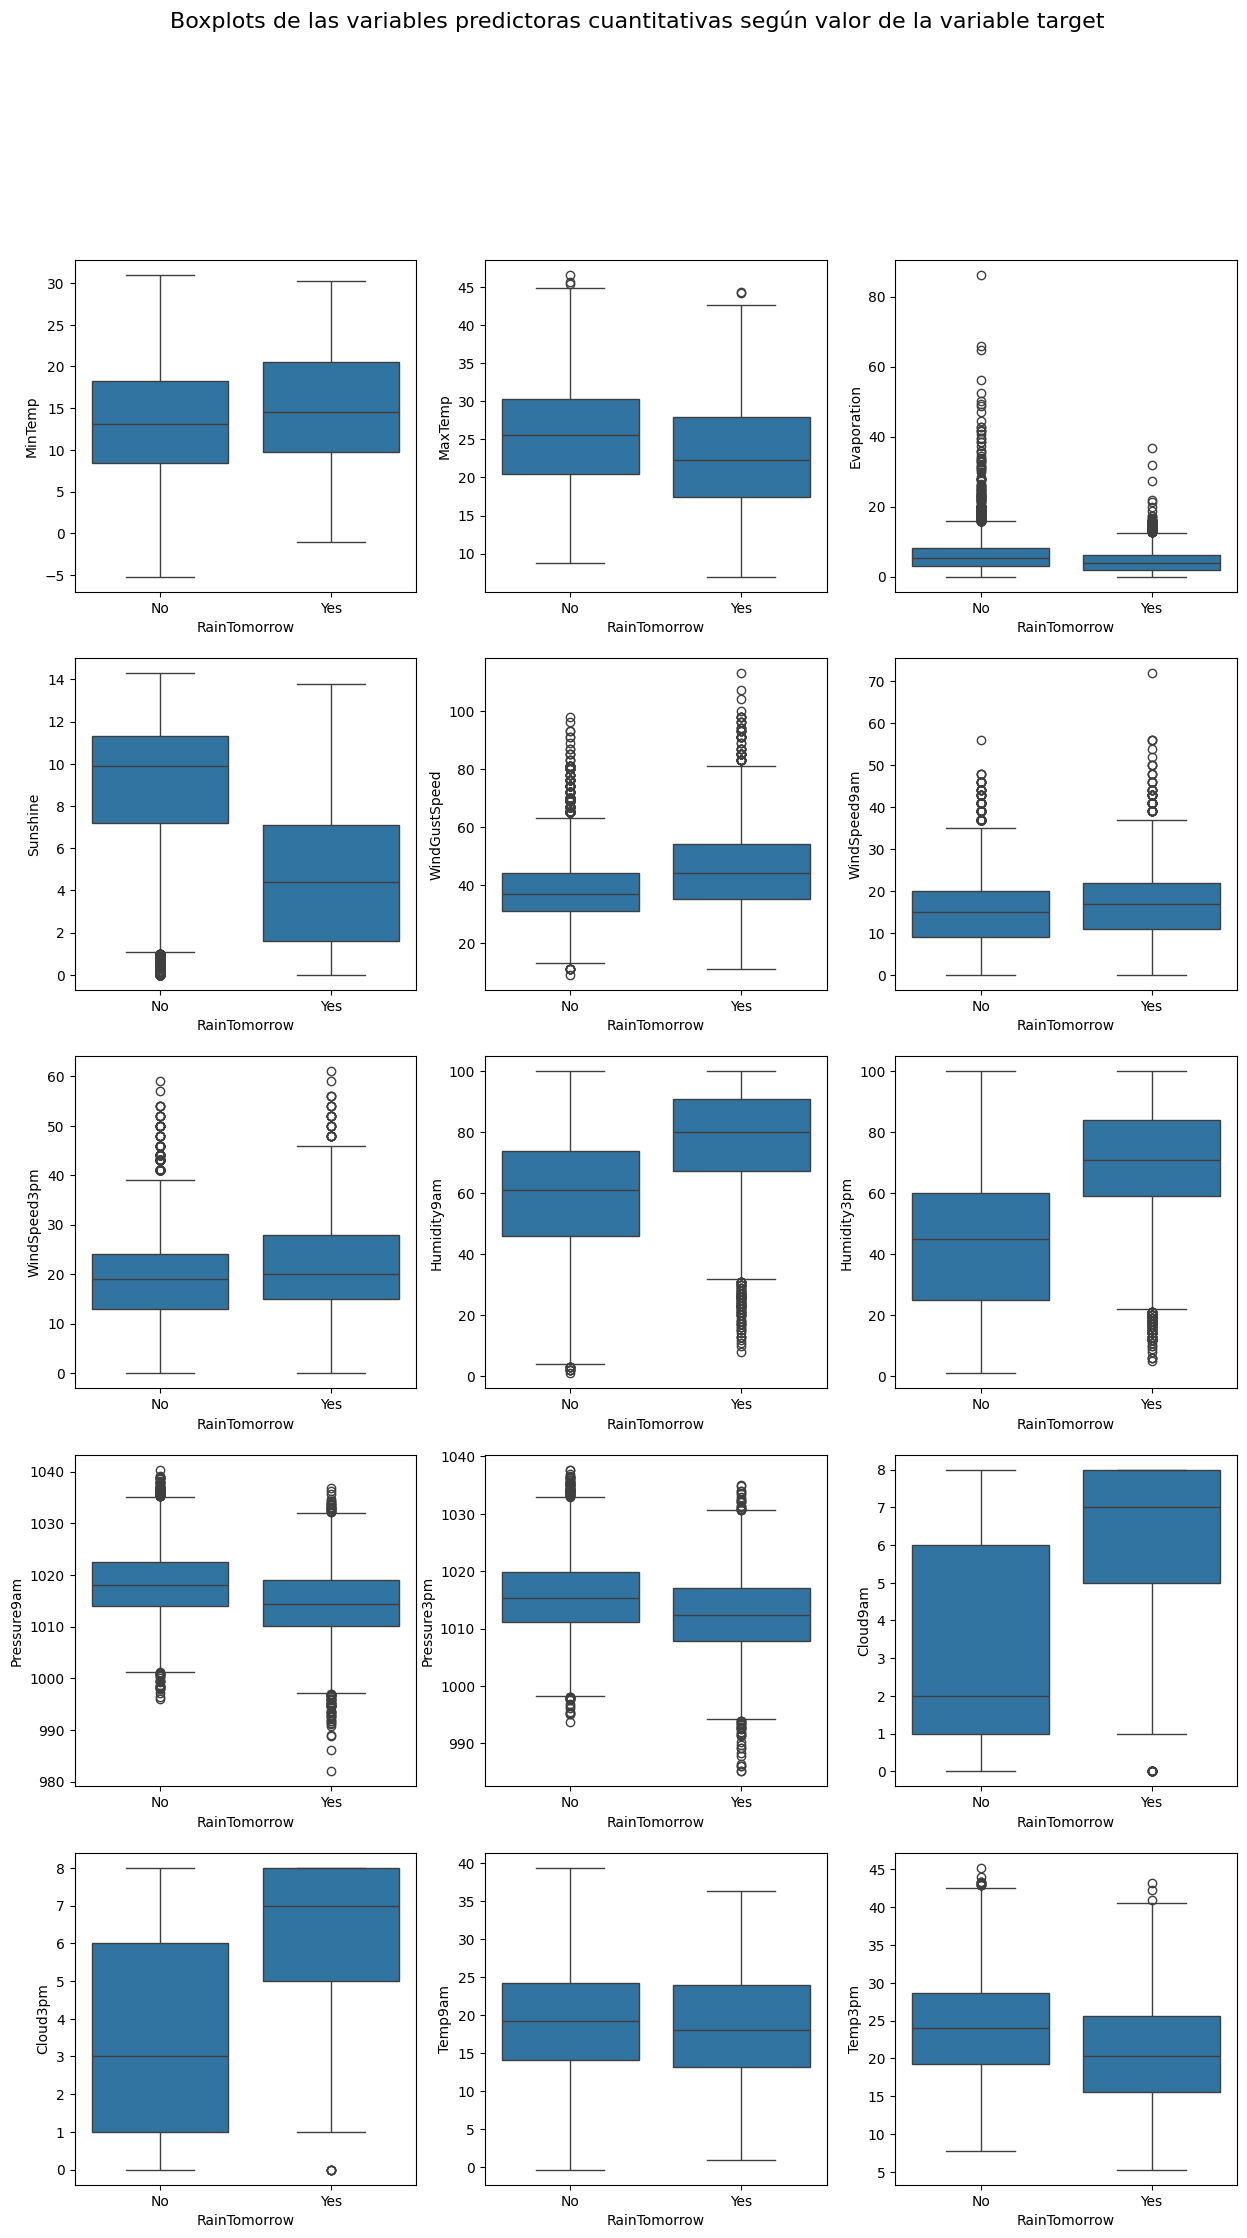

In [24]:
# A la función puede recibir el string boxplots, caso contrario grafica histogramas
visualizar_features_cuanti_sin_lluvia('boxplots')

ADVERTENCIA: Se observa que las features vinculadas con la nubosidad (sunshine | cloud 9 am | cloud 3 pm)
son muy importante para explicar la variable target, sin embargo, para un alto porcentaje de las observaciones no se dispone de los datos relativos a la nubosidad. 

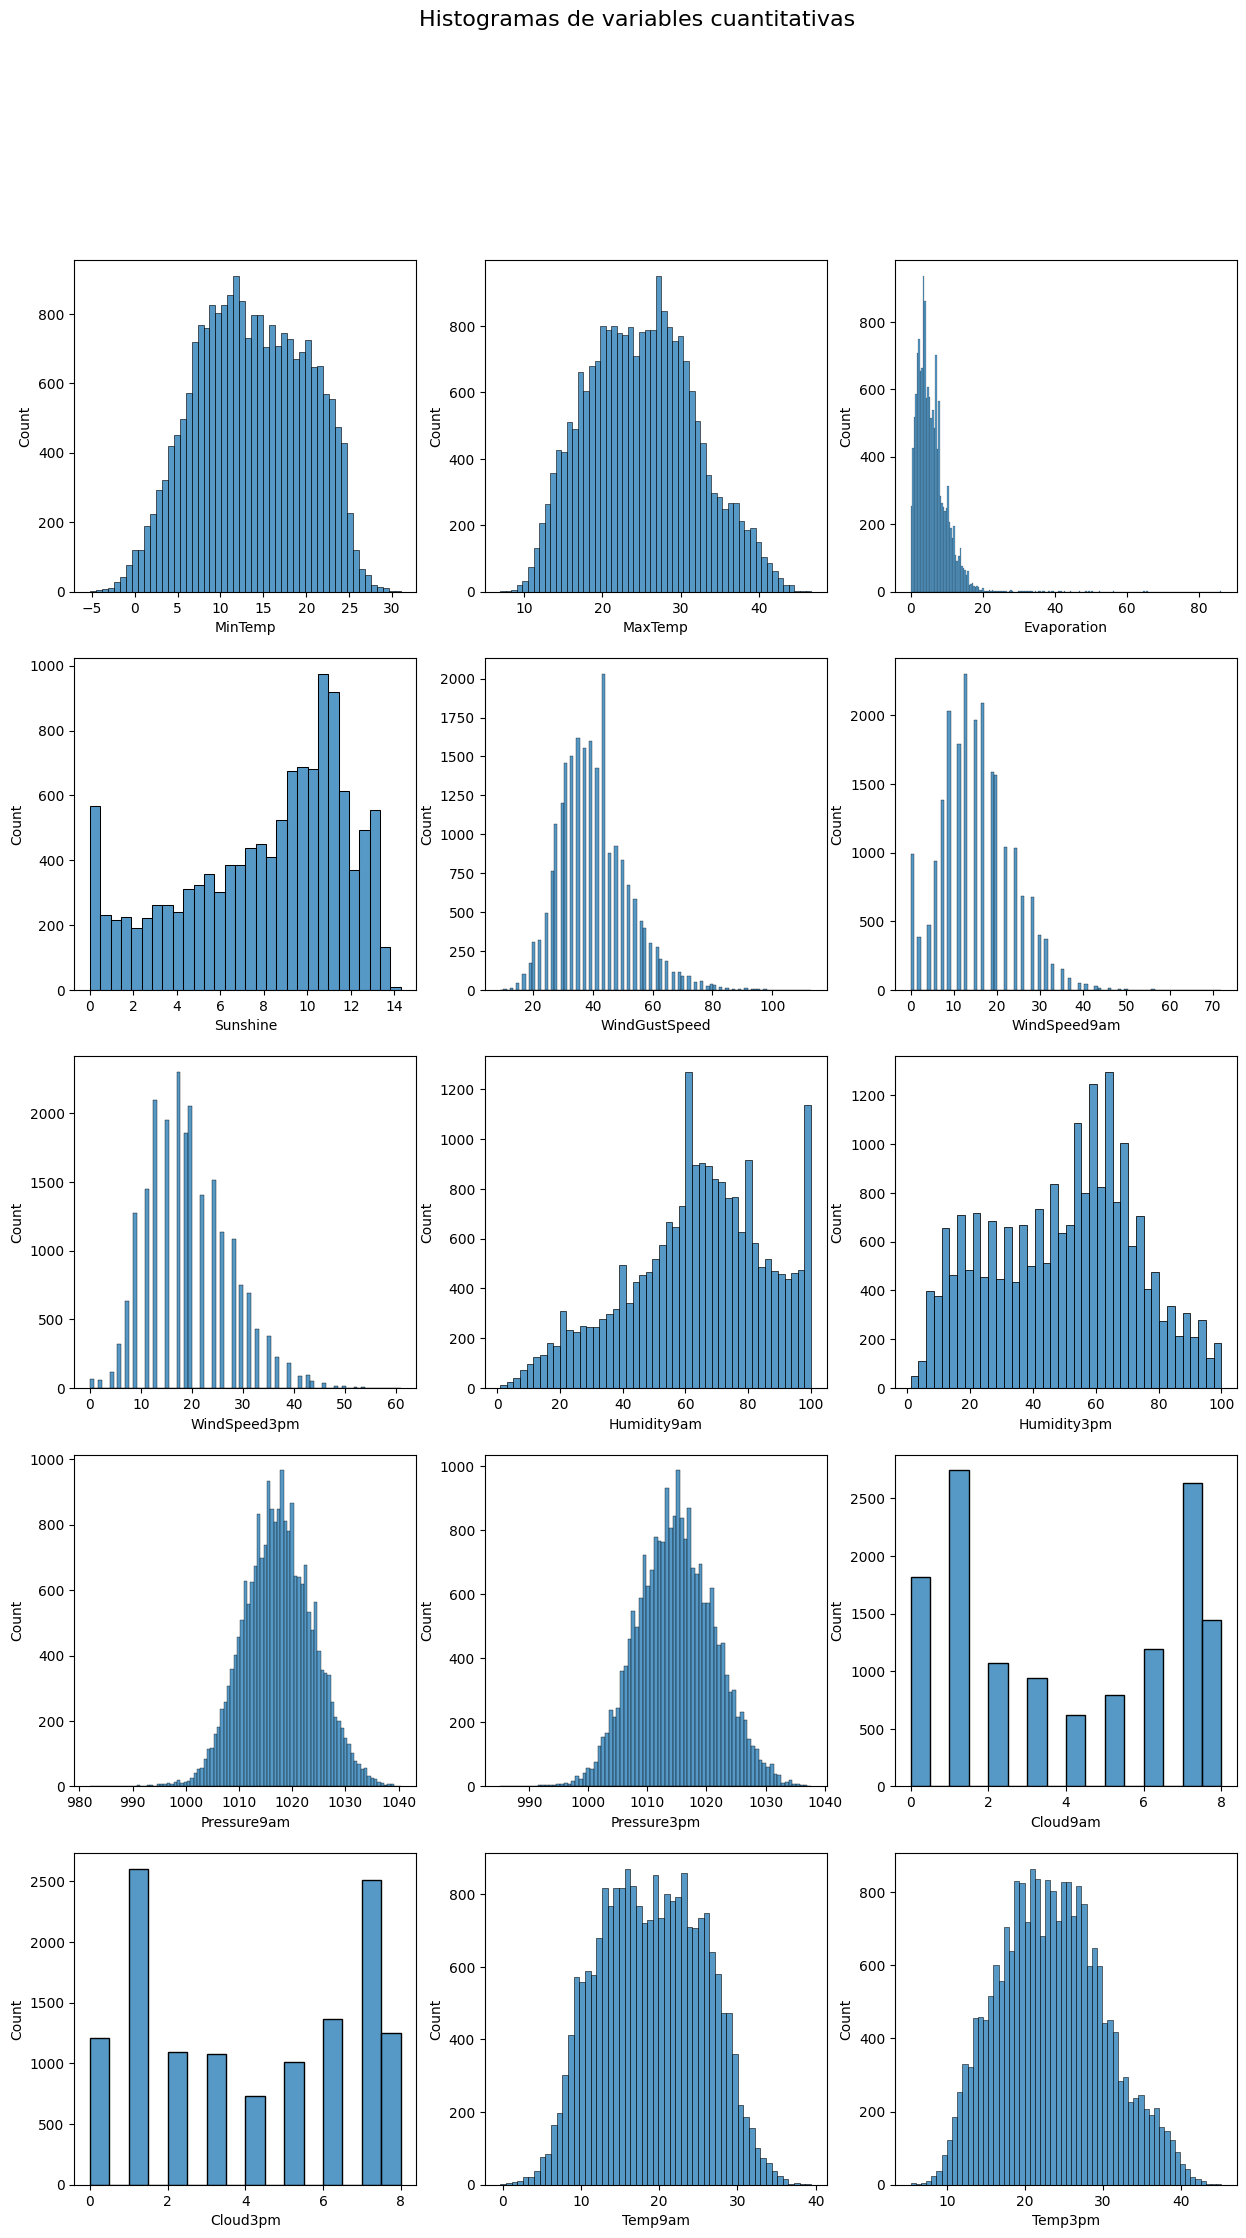

In [25]:
visualizar_features_cuanti_sin_lluvia('histogramas')

El análisis de los histogramas serán tenidos en cuenta para la imputación de faltantes.
Se observa que las siguientes features son 
* simétricas:
Temperatura (en todas sus versiones)
* asimétricas:
Evaporación | Viento (en todas sus versiones) | Humedad (en todas sus versiones) | Presión (en todas sus versiones)
* bimodales:
Nubosidad (en todas sus versiones) | Radiación Solar

Se observa que existe cierto grado de correlación positiva entre esas variables cualitativas

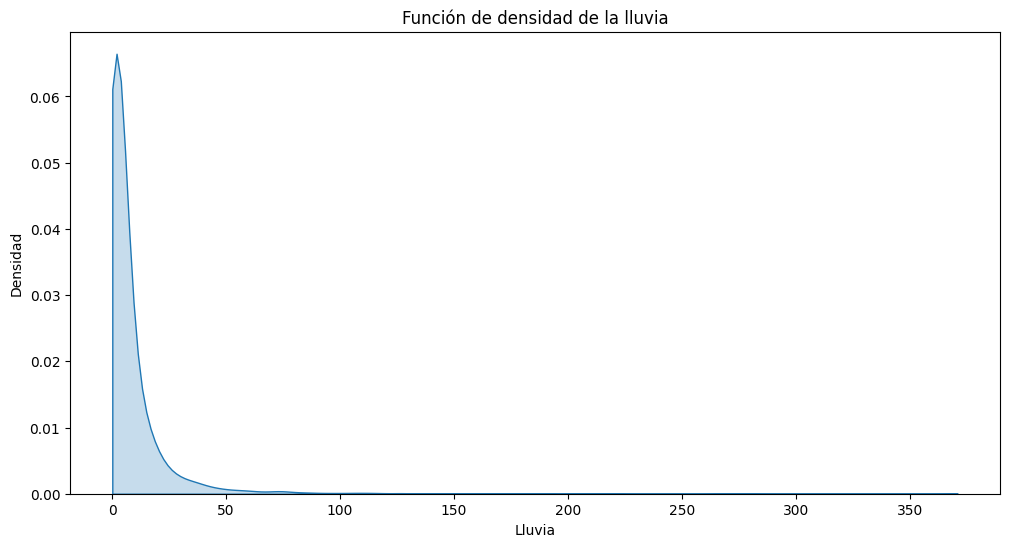

In [26]:
# Se grafica la función de densidad de la feature Rainfall para aquellos días que llovió
s_lluvia = X_train[X_train['Rainfall']>0]['Rainfall']
bandwidth = 1.5
plt.figure(figsize=(12, 6))
sns.kdeplot(data=s_lluvia, fill=True, bw_adjust=bandwidth,cut=0)
plt.title('Función de densidad de la lluvia')
plt.xlabel('Lluvia')
plt.ylabel('Densidad')
current_values = plt.gca().get_xticks()
plt.show()

In [27]:
# Se construye esta tabla para evidenciar la presencia de valores fuertemente atípicos para la variable llvua
rangos_lluvia = pd.cut(s_lluvia,bins=range(0,401,50), right=True)
df_frec_lluvia = rangos_lluvia.value_counts().sort_index().reset_index()
df_frec_lluvia.rename(columns={'Rainfall':'Rainfall','count':'Frecuencia_absoluta'},inplace=True)
df_frec_lluvia.set_index('Rainfall',inplace=True)
df_frec_lluvia['Frecuencia_relativa'] = round(df_frec_lluvia['Frecuencia_absoluta'] / df_frec_lluvia['Frecuencia_absoluta'].sum(),2)
df_frec_lluvia['Frecuencia_absoluta_acumulada'] = df_frec_lluvia['Frecuencia_absoluta'].cumsum()
df_frec_lluvia['Frecuencia_relativa_acumulada'] = df_frec_lluvia['Frecuencia_relativa'].cumsum()
df_frec_lluvia

,Frecuencia_absoluta,Frecuencia_relativa,Frecuencia_absoluta_acumulada,Frecuencia_relativa_acumulada
Rainfall,,,,
"(0, 50]",7418,0.98,7418,0.98
"(50, 100]",117,0.02,7535,1.00
"(100, 150]",31,0.00,7566,1.00
"(150, 200]",11,0.00,7577,1.00
"(200, 250]",3,0.00,7580,1.00
"(250, 300]",2,0.00,7582,1.00
"(300, 350]",0,0.00,7582,1.00
"(350, 400]",1,0.00,7583,1.00


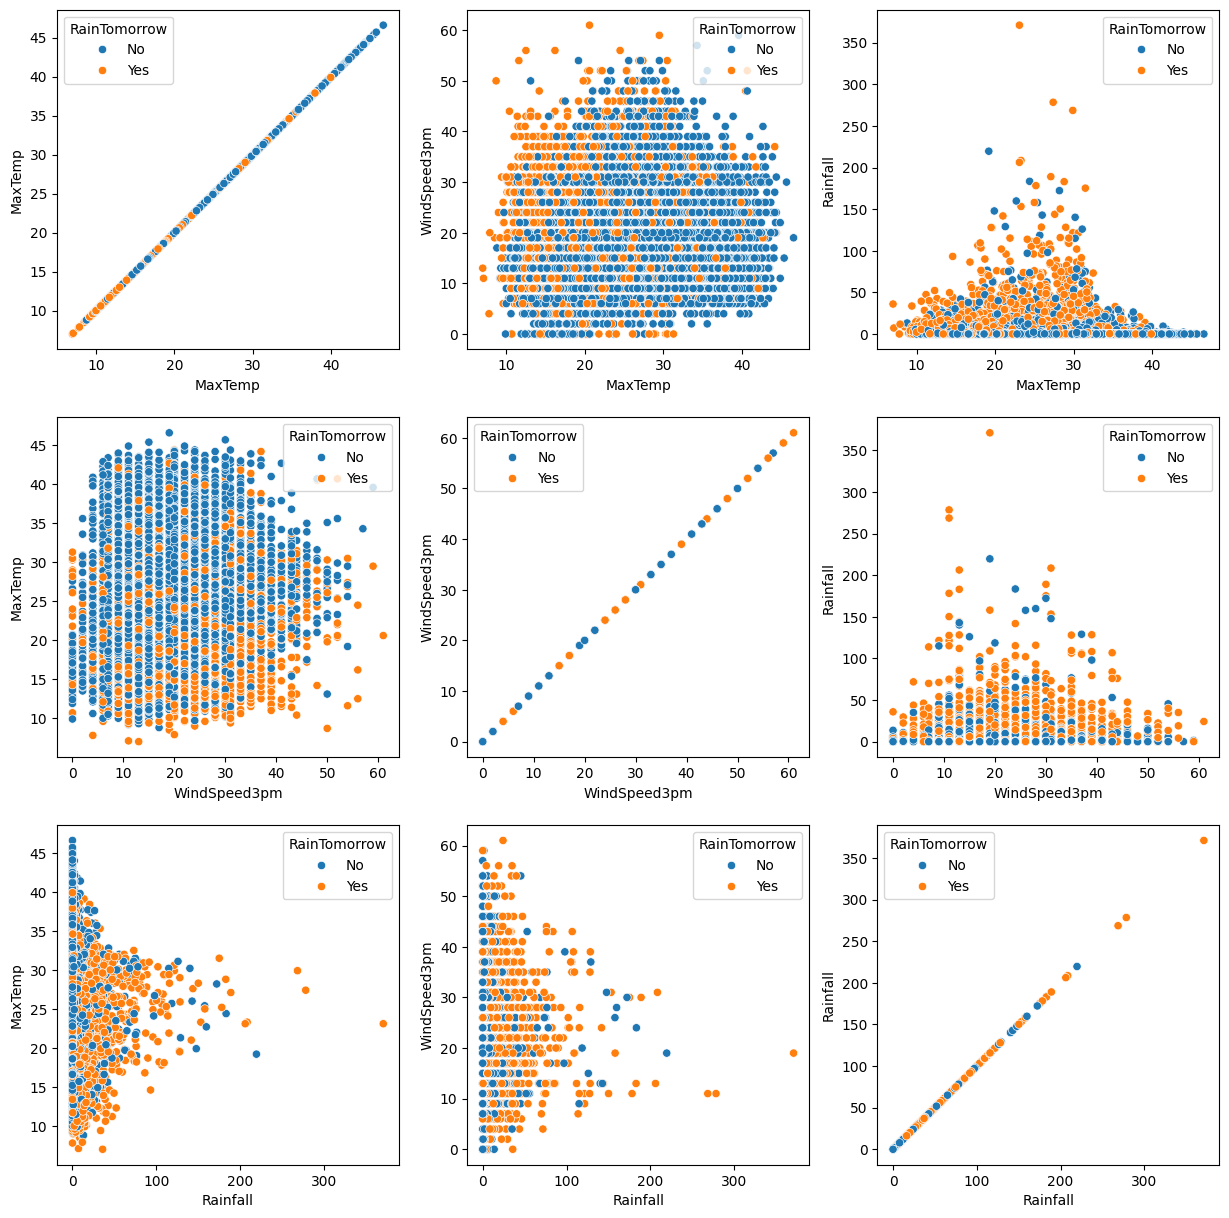

In [28]:
# Por la imposiblidad de ver todos los scatter plot posibles entre cuantitativas, se eligen
#3 features
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
columns = ['MaxTemp','WindSpeed3pm','Rainfall']
fig.subplots_adjust(hspace=0.2)
i = 0
for col in columns:
    j = 0
    for col2 in columns:
        #agregamos labels para usarlas luego
        sns.scatterplot(data=df_train, x=col, y=col2, hue="RainTomorrow",ax=axs[i,j]) 
        j+=1
    i+=1
plt.show()

In [29]:
# Correlación entre variables cualitativas incluyendo la target
df_corr_rain_cuali = pd.DataFrame({
    'RainToday': ['RainToday_Yes','RainToday_Yes','RainToday_No','RainToday_No'],
    'RainTomorrow': ['RainTomorrow_Yes','RainTomorrow_No','RainTomorrow_Yes','RainTomorrow_No'],
    'Frec_abs': [None,None,None,None]
})
df_corr_rain_cuali.loc[0,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[1,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='No')])
df_corr_rain_cuali.loc[2,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[3,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='No')])

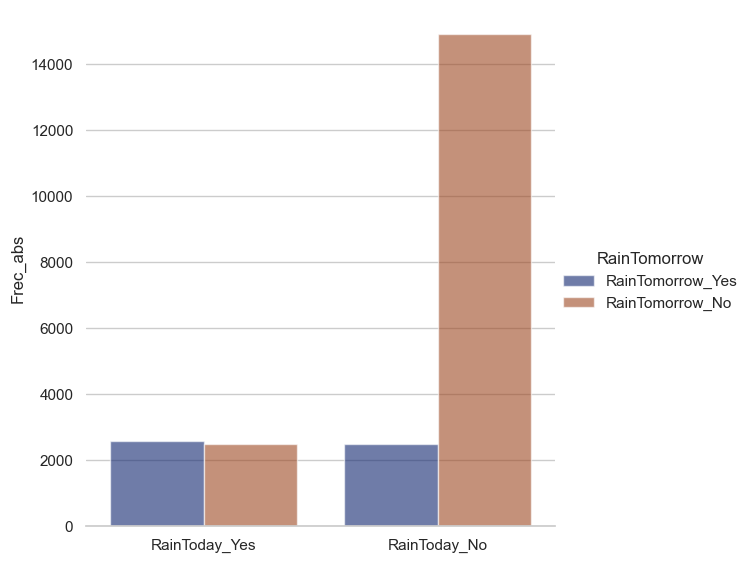

In [30]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df_corr_rain_cuali, kind="bar",
    x="RainToday", y="Frec_abs", hue="RainTomorrow",
    errorbar=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Frec_abs")
g.set_titles('Visualización de correlación entre variables cuantitativas')
plt.show()

### Matriz de correlación de variables

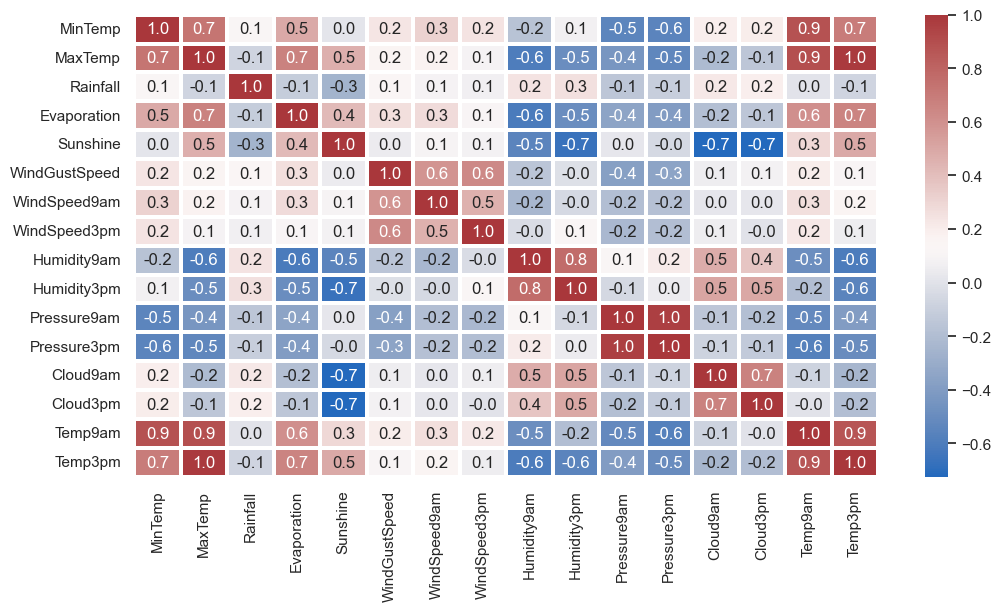

In [31]:
plt.figure(figsize=(12, 6))
sns.heatmap(data=df_train[features_cuanti].corr(),annot=True,fmt=".1f",linewidths=1.5,cmap='vlag')
plt.show()

La colinealidad es un rango entre las features. Por un lado, se observa una correlación lineal positiva fuerte entre variables meteorológicas que únicamente difieren en la hora del día en el que fueron registradas. Por el otro, se verifica una correlación negativa de gran intensidad entre variables que naturalmente tienen comportamientos opuestos como la feature sunshine y las features vinculadas con la medición de la nubosidad.

### Análisis de balanceo del dataset 

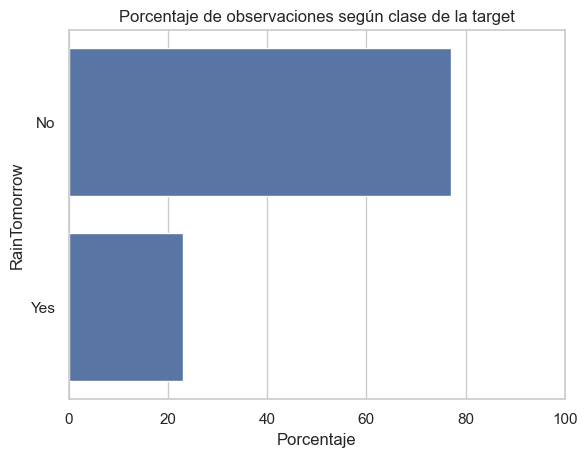

In [32]:
# Análisis de balanceo del df de entrenamiento
balanceo = round(y_train.value_counts() / len(y_train) *100,0)
sns.barplot(balanceo,orient='y')
plt.ylabel('RainTomorrow')
plt.xlabel('Porcentaje')
plt.xlim((0,100))
plt.title('Porcentaje de observaciones según clase de la target')
plt.show()

El dataframe de entrenamiento no está balanceado debido a que más del 75% de las observaciones totales pertenecen a la variable target negativa. Es importante este análisis porque al estar desbalanceado corresponde aplicar las técnicas de oversumpling, undersumpling o discriminación de penalidad asignada a cada clase para evitar que modelo tienda a predecir la categoría mayoritaria.  

### Análisis y decisión sobre datos faltantes y atípicos

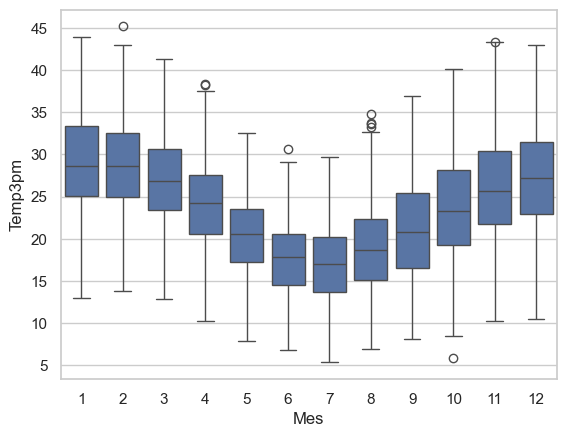

In [33]:
# Se analiza el caso de features que presentan un significativo comportamiento estacional
# y por ende puede que se justifique imputar faltantes aplicando un estadístico segmentado por mes
sns.boxplot(data=df_train,y='Temp3pm',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

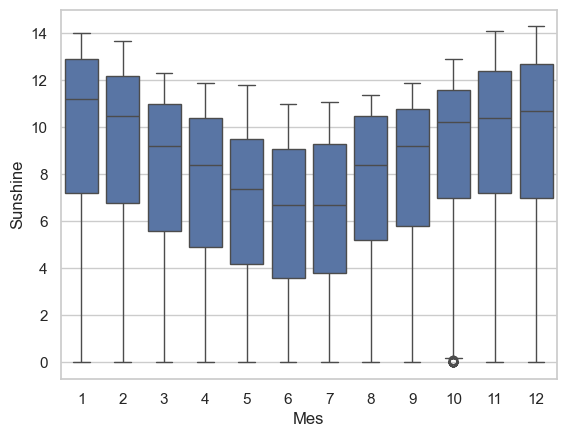

In [34]:
sns.boxplot(data=df_train,y='Sunshine',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

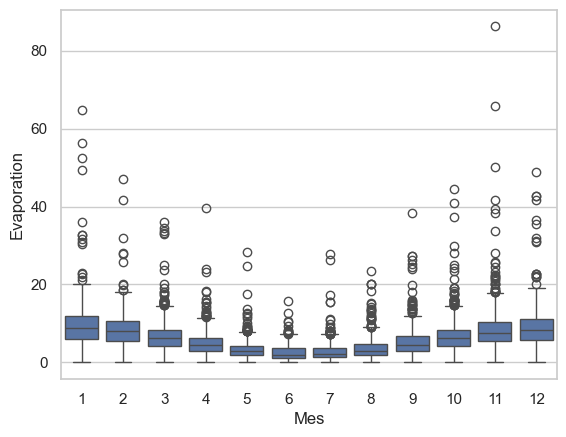

In [35]:
sns.boxplot(data=df_train,y='Evaporation',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

In [36]:
X_train.isna().sum()

Date                0
MinTemp            20
MaxTemp            13
Rainfall           24
Evaporation      7418
Sunshine         9658
WindGustDir       172
WindGustSpeed     166
WindDir9am        985
WindDir3pm         67
WindSpeed9am       14
WindSpeed3pm       11
Humidity9am       200
Humidity3pm       200
Pressure9am        22
Pressure3pm        16
Cloud9am         8846
Cloud3pm         9230
Temp9am             3
Temp3pm             1
RainToday          24
Month               0
dtype: int64

In [37]:
# Tratamiento de faltantes en features con una alta proporción de valores faltantes
# que justifican imputar por media segmentada
X_train_media_seg_sunshine_by_mes = X_train.groupby(X_train['Date'].dt.month)['Sunshine'].transform('mean')
X_train_media_seg_cloud9am_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud9am'].transform('mean')
X_train_media_seg_cloud3pm_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud3pm'].transform('mean')
X_train_media_seg_evaporation_by_mes = X_train.groupby(X_train['Date'].dt.month)['Evaporation'].transform('mean')
X_train_imputed = X_train.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})
X_test_imputed = X_test.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})

In [38]:
# Tratamiento de faltantes en features cualitativas
X_train_moda_dir_nudo_viento = X_train['WindGustDir'].mode()[0]
X_train_moda_dir_viento9am = X_train['WindDir9am'].mode()[0]
X_train_moda_dir_viento3pm = X_train['WindDir3pm'].mode()[0]
X_train_moda_raintoday = X_train['RainToday'].mode()[0]
X_train_imputed = X_train_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})
X_test_imputed = X_test_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})

In [39]:
# Reducción de la cantidad de categorías correspondientes con la dirección del viento. De 16 a 4.
direction_dict = {
    'SSW':'S',
    'S':'S',
    'SE':'S',
    'NNE':'N',
    'WNW':'W',
    'N':'N',
    'ENE':'E',
    'NE':'N',
    'E':'E',
    'SW':'S',
    'W':'W',
    'WSW':'W',
    'NNW':'N',
    'ESE':'E',
    'SSE':'S',
    'NW':'N'
}
for feature_cuali in features_cuali[:3]:
    X_train_imputed[feature_cuali] = X_train_imputed[feature_cuali].map(direction_dict)
    X_test_imputed[feature_cuali] = X_test_imputed[feature_cuali].map(direction_dict)
X_train_imputed.loc[0]

Date             2016-06-01 00:00:00
MinTemp                         11.9
MaxTemp                         23.2
Rainfall                         0.0
Evaporation                      2.6
Sunshine                    6.151357
WindGustDir                        E
WindGustSpeed                   30.0
WindDir9am                         E
WindDir3pm                         E
WindSpeed9am                     7.0
WindSpeed3pm                    19.0
Humidity9am                     77.0
Humidity3pm                     61.0
Pressure9am                   1020.9
Pressure3pm                   1018.4
Cloud9am                    4.305944
Cloud3pm                    4.352346
Temp9am                         17.4
Temp3pm                         22.4
RainToday                         No
Month                            jun
Name: 0, dtype: object

In [40]:
# Tratamiento de faltantes en features asimétricas que justican imputar por mediana simple
X_train_mediana_WindGustSpeed = X_train['WindGustSpeed'].median()
X_train_mediana_Humidity9am = X_train['Humidity9am'].median()
X_train_mediana_Humidity3pm = X_train['Humidity3pm'].median()
X_train_mediana_Rainfall = X_train['Rainfall'].median()
X_train_mediana_WindSpeed9am = X_train['WindSpeed9am'].median()
X_train_mediana_WindSpeed3pm = X_train['WindSpeed3pm'].median()
X_train_mediana_Pressure9am  = X_train['Pressure9am'].median()
X_train_mediana_Pressure3pm = X_train['Pressure3pm'].median()

X_train_imputed = X_train_imputed.fillna({
    'WindGustSpeed': X_train_mediana_WindGustSpeed,
    'Humidity9am': X_train_mediana_Humidity9am,
    'Humidity3pm': X_train_mediana_Humidity3pm,
    'Rainfall': X_train_mediana_Rainfall,
    'WindSpeed9am': X_train_mediana_WindSpeed9am,
    'WindSpeed3pm': X_train_mediana_WindSpeed3pm,
    'Pressure9am': X_train_mediana_Pressure9am,
    'Pressure3pm': X_train_mediana_Pressure3pm,
})
X_test_imputed = X_test_imputed.fillna({
    'WindGustSpeed': X_train_mediana_WindGustSpeed,
    'Humidity9am': X_train_mediana_Humidity9am,
    'Humidity3pm': X_train_mediana_Humidity3pm,
    'Rainfall': X_train_mediana_Rainfall,
    'WindSpeed9am': X_train_mediana_WindSpeed9am,
    'WindSpeed3pm': X_train_mediana_WindSpeed3pm,
    'Pressure9am': X_train_mediana_Pressure9am,
    'Pressure3pm': X_train_mediana_Pressure3pm,
})

In [41]:
# Tratamiento de faltantes en features simétricas que justican imputar por media simple
X_train_mean_MinTemp = X_train['MinTemp'].mean()
X_train_mean_MaxTemp = X_train['MaxTemp'].mean()
X_train_mean_Temp9am = X_train['Temp9am'].mean()
X_train_mean_Temp3pm = X_train['Temp3pm'].mean()


X_train_imputed = X_train_imputed.fillna({
    'MinTemp': X_train_mean_MinTemp,
    'MaxTemp': X_train_mean_MaxTemp,
    'Temp9am': X_train_mean_Temp9am,
    'Temp3pm': X_train_mean_Temp3pm,
})
X_test_imputed = X_test_imputed.fillna({
    'MinTemp': X_train_mean_MinTemp,
    'MaxTemp': X_train_mean_MaxTemp,
    'Temp9am': X_train_mean_Temp9am,
    'Temp3pm': X_train_mean_Temp3pm,
})

In [42]:
X_train_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Month            0
dtype: int64

In [43]:
# Tratamiento de valores atípicos para la feature Rainfall
# La lluvia presenta una significatía asimetría positiva. Para evitar distorsiones sobre el valor de los 
# parámetros del modelo, se imputan los valores atípicos de esta variable en base al mayor valor típico observado 
# para la variable en cuestión.
s_lluvia = X_train_imputed[X_train_imputed['Rainfall']>0]['Rainfall']
q1 , q3 = s_lluvia.quantile(q=[0.25,0.75])
r_i = q3 - q1
valor_tipico_sup = q3 + 1.5 * r_i
# Imputacion para train
X_train_imputed_idx_lluvia_ati = X_train_imputed[X_train_imputed['Rainfall']>valor_tipico_sup].index
X_train_imputed.loc[X_train_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup
# Imputacion para test
X_test_encoded_imputed_idx_lluvia_ati = X_test_imputed[X_test_imputed['Rainfall']>valor_tipico_sup].index
X_test_imputed.loc[X_test_encoded_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup

### Codificación de variables categóricas

In [44]:
def codificar_features_cuanti(data_set,col_catego):
    """Recibe un data frame y sus columnas categoricas y 
    devuelve el data frame transformado con la correspondiente 
    codificación de estas columnas"""
    encoder = OneHotEncoder(sparse_output=False,drop='first')
    one_hot_encoded = encoder.fit_transform(data_set[col_catego])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(col_catego))
    df_encoded = pd.concat([data_set, one_hot_df], axis=1)
    df_encoded = df_encoded.drop(col_catego, axis=1)
    return df_encoded


In [45]:
def codificar_target(serie:pd.Series):
    """Recibe una serie para cambiar el nombre y a su vez mapear 
    sus valores para codificarlos"""
    serie.name ='RainTomorrow_Yes'
    serie_codificada =  serie.map({"No":0,"Yes":1})
    return serie_codificada

In [46]:
#Codificación de features categóricas
X_train_encoded_imputed = codificar_features_cuanti(X_train_imputed,features_cuali)
X_test_encoded_imputed = codificar_features_cuanti(X_test_imputed,features_cuali)

In [47]:
X_train_encoded_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
WindGustDir_N    0
WindGustDir_S    0
WindGustDir_W    0
WindDir9am_N     0
WindDir9am_S     0
WindDir9am_W     0
WindDir3pm_N     0
WindDir3pm_S     0
WindDir3pm_W     0
RainToday_Yes    0
Month_ago        0
Month_dic        0
Month_ene        0
Month_feb        0
Month_jul        0
Month_jun        0
Month_mar        0
Month_may        0
Month_nov        0
Month_oct        0
Month_sep        0
dtype: int64

In [48]:
#Codificación de la target 
y_train_encoded = codificar_target(y_train)
y_test_encoded = codificar_target(y_test)
y_test_encoded

0       0
1       0
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: RainTomorrow_Yes, Length: 5647, dtype: int64

In [49]:
X_train_encoded_imputed.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W',
       'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N',
       'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'Month_ago',
       'Month_dic', 'Month_ene', 'Month_feb', 'Month_jul', 'Month_jun',
       'Month_mar', 'Month_may', 'Month_nov', 'Month_oct', 'Month_sep'],
      dtype='object')

In [50]:
print("X_train_imputed\n",X_train_imputed.head(5))
print("X_train_encoded_imputed\n",X_train_encoded_imputed.head(5))

X_train_imputed
         Date  MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine WindGustDir  \
0 2016-06-01     11.9     23.2       0.0          2.6   6.151357           E   
1 2009-10-13      8.9     20.7       0.0          4.2   8.500000           W   
2 2009-02-28     22.2     36.9       0.0          9.4  12.000000           W   
3 2014-09-12      8.7     21.9       0.0          6.2   7.956054           S   
4 2016-01-22     16.5     30.4       0.0          8.2  13.100000           E   

   WindGustSpeed WindDir9am WindDir3pm  ...  Humidity9am  Humidity3pm  \
0           30.0          E          E  ...         77.0         61.0   
1           41.0          S          W  ...         61.0         46.0   
2           41.0          N          W  ...         41.0         18.0   
3           33.0          E          S  ...         39.0         24.0   
4           39.0          E          S  ...         46.0         38.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3

### Escalado de datos 

In [51]:
# Escalado de datos - NO SE ESCALAN VARIABLES CUALITATIVAS
scaler = StandardScaler()
X_train_encoded_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded_imputed[features_cuanti]), columns=features_cuanti)
X_test_encoded_imputed_scaled = pd.DataFrame(scaler.transform(X_test_encoded_imputed[features_cuanti]), columns=features_cuanti)


In [52]:
# Primero se filtra para eliminar las cuantitativas no escaladas para luego unir 
# las cualitativas con las cuantitativas sí escaladas
X_train_encoded_imputed_cuali = X_train_encoded_imputed.drop(features_cuanti,axis=1)
X_train_encoded_imputed_cuantiscaled_cuali = pd.concat([X_train_encoded_imputed_scaled,X_train_encoded_imputed_cuali],axis=1)

X_test_encoded_imputed_cuali = X_test_encoded_imputed.drop(features_cuanti,axis=1)
X_test_encoded_imputed_cuantiscaled_cuali = pd.concat([X_test_encoded_imputed_scaled,X_test_encoded_imputed_cuali],axis=1)

In [53]:
X_train_encoded_imputed_cuantiscaled_cuali 
y_test_encoded
X_test_encoded_imputed_cuantiscaled_cuali 
y_test_encoded

0       0
1       0
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: RainTomorrow_Yes, Length: 5647, dtype: int64

## 2. Regresión Logística

In [54]:
#Observo columnas de X_train_encoded_imputed_cuantiscaled_cuali
print(X_train_encoded_imputed_cuantiscaled_cuali.columns)
print("Cant. de columnas: ", len(X_train_encoded_imputed_cuantiscaled_cuali.columns))

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Date', 'WindGustDir_N', 'WindGustDir_S',
       'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W',
       'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes',
       'Month_ago', 'Month_dic', 'Month_ene', 'Month_feb', 'Month_jul',
       'Month_jun', 'Month_mar', 'Month_may', 'Month_nov', 'Month_oct',
       'Month_sep'],
      dtype='object')
Cant. de columnas:  38


In [55]:
# Eliminar la columna 'Date' de los conjuntos ( nos quedamos con los meses)
x_train_clean = X_train_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])
x_test_clean = X_test_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])

# No es necesario modificar y_train y y_test
y_train_clean = y_train_encoded
y_test_clean = y_test_encoded

In [56]:
# Mostrar las dimensiones de X_train_clean
print("Dimensiones de X_train_clean:", x_train_clean.shape)
print("Dimensiones de y_train_clean:", y_train_clean.shape)   # Mostrar las dimensiones de y_train_clean
print("Dimensiones de X_test_clean:", x_test_clean.shape)
print("Dimensiones de y_test_clean:", y_test_clean.shape)


Dimensiones de X_train_clean: (22047, 37)
Dimensiones de y_train_clean: (22047,)
Dimensiones de X_test_clean: (5647, 37)
Dimensiones de y_test_clean: (5647,)


### Regresión Logistica Base (Sin balancear)

In [57]:
# Entrenamos Regresion Logistica básica sin ajustar parametros.
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(x_train_clean, y_train_clean)
y_pred = logistic_model.predict(x_test_clean)

print("Resultados con regresión logística\n")
print(classification_report(y_test_clean, y_pred))
print(confusion_matrix(y_test_clean, y_pred))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4373
           1       0.75      0.57      0.65      1274

    accuracy                           0.86      5647
   macro avg       0.81      0.76      0.78      5647
weighted avg       0.85      0.86      0.85      5647

[[4125  248]
 [ 549  725]]


$$
\text{Balanced Accuracy} = \frac{1}{2} \left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$


In [58]:
# Calcular Balanced Accuracy
balanced_acc_rl = balanced_accuracy_score(y_test_clean, y_pred)

print(f'Balanced Accuracy Reg. Logistica Base: {balanced_acc_rl:.2f}')

Balanced Accuracy Reg. Logistica Base: 0.76


In [59]:
cf_matrix = confusion_matrix(y_test_clean, y_pred)

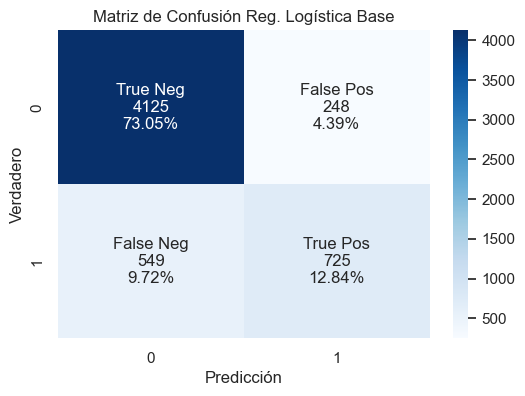

In [60]:
# Matriz de confusión con Heatmap.
labels = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Ajustar el tamaño de la figura
plt.figure(figsize=(6, 4))  
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

plt.title('Matriz de Confusión Reg. Logística Base', fontsize=12)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

##### Curva ROC y AUC 

In [61]:
# Obtengo las probabilidades de predicción del modelo
y_probs_reglog= logistic_model.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_rl, tpr_rl, thresholds_rl = roc_curve(y_test_clean, y_probs_reglog)
roc_auc_rl = auc(fpr_rl, tpr_rl)

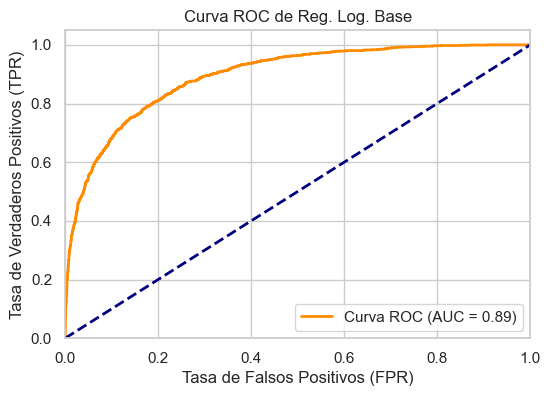

In [62]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_rl, tpr_rl, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_rl)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Base')
plt.legend(loc="lower right")
plt.show()

### Regresión Logística Balanceada.

In [63]:
logistic_model_balanced = LogisticRegression(random_state=42, class_weight= "balanced")
logistic_model_balanced.fit(x_train_clean, y_train_clean)
y_pred_balanced = logistic_model_balanced.predict(x_test_clean)

print("Resultados con regresión logística\n")
print(classification_report(y_test_clean, y_pred_balanced))
print(confusion_matrix(y_test_clean, y_pred_balanced))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      4373
           1       0.55      0.80      0.65      1274

    accuracy                           0.81      5647
   macro avg       0.74      0.80      0.76      5647
weighted avg       0.85      0.81      0.82      5647

[[3531  842]
 [ 254 1020]]


In [83]:
# Calcular Balanced Accuracy
balanced_acc_balanced = balanced_accuracy_score(y_test_clean, y_pred_balanced)

print(f'Balanced Accuracy Reg. Logistica Balanceada: {balanced_acc_balanced:.2f}')

Balanced Accuracy Reg. Logistica Balanceada: 0.80


In [64]:
cf_matrix_b = confusion_matrix(y_test_clean, y_pred_balanced)

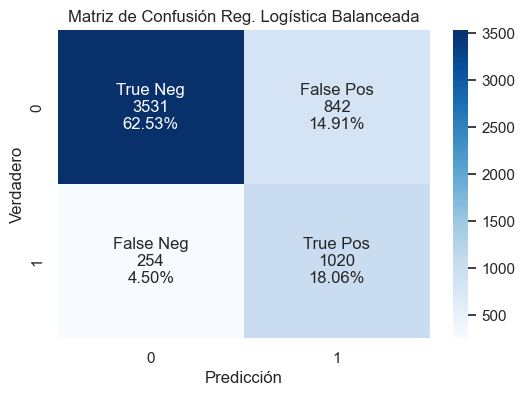

In [65]:
# Matriz de confusión con Heatmap.
labels = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_b.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_b.flatten()/np.sum(cf_matrix_b)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6, 4))  
sns.heatmap(cf_matrix_b, annot=labels, fmt="", cmap='Blues')

plt.title('Matriz de Confusión Reg. Logística Balanceada', fontsize=12)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

##### Curva ROC y AUC 

In [66]:
# Obtengo las probabilidades de predicción del modelo
y_probs_balanced = logistic_model_balanced.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_ba, tpr_ba, thresholds_ba = roc_curve(y_test_clean, y_probs_balanced)
roc_auc = auc(fpr_ba, tpr_ba)

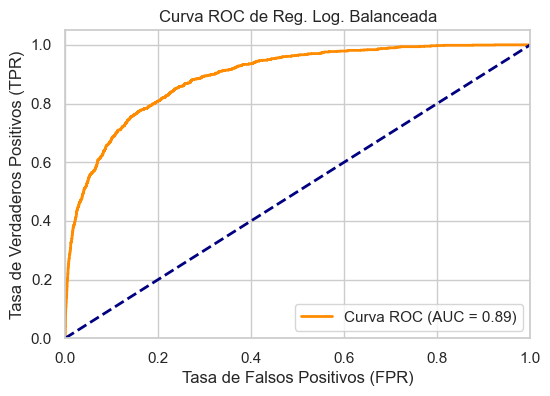

In [67]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_ba, tpr_ba, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Balanceada')
plt.legend(loc="lower right")
plt.show()

Umbral óptimo: Calcular la distancia euclidiana de cada punto de la curva ROC a punto(0,1) o AUC=1:

$\text{distancia} = \sqrt{(\text{FPR})^2 + (1 - \text{TPR})^2}$

Mejor umbral: 0.5481211805112595
Distancia mínima al punto perfecto: 0.27491788516366916


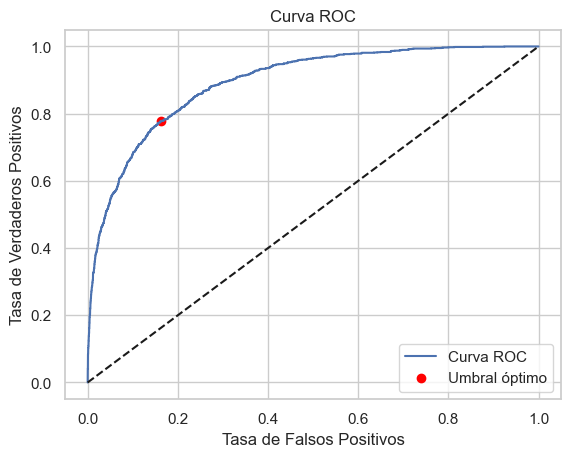

In [68]:
# Encontrar umbral optimo por distancia a punto (0,1), donde AUC = 1
"""Calcula la curva ROC con las etiquetas verdaderas y las probabilidades de clase positiva.
   Calcula la distancia euclidiana de cada punto de la curva al punto perfecto (0,1).
   Encuentra el umbral que minimiza esta distancia
"""

# Calcular la distancia al punto perfecto
distances = np.sqrt(fpr_ba**2 + (1 - tpr_ba)**2)

# Encontrar el índice del umbral que minimiza la distancia
min_distance_index = np.argmin(distances)
best_threshold = thresholds_ba[min_distance_index]
best_distance = distances[min_distance_index]

print("Mejor umbral:", best_threshold)
print("Distancia mínima al punto perfecto:", best_distance)

import matplotlib.pyplot as plt

plt.plot(fpr_ba, tpr_ba, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.scatter(fpr_ba[min_distance_index], tpr_ba[min_distance_index], color='red', label='Umbral óptimo')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

- Precisión (Accuracy): Es la proporción de predicciones correctas realizadas por el modelo sobre el total de predicciones realizadas.
    - Correctas / Totales

- Recall (Recall o Sensibilidad): Es la proporción de instancias positivas que el modelo predijo correctamente respecto a todas las instancias positivas reales.
    - VP / (VP + FN)

- F1-score: Es la media armónica de precisión y recall. Proporciona una medida única que combina ambos aspectos del rendimiento del modelo.
    - Precisión x Recall / (Precisión + Recall)

- Soporte (Support): Es el número de instancias en el conjunto de datos que pertenecen a cada clase. Ayuda a entender cuán representativas son las muestras de cada clase.

### Regresión Log. Balanceada con Regularización

In [69]:
# Crear un modelo de regresión logística con regularización L1 (Lasso)
# Ajusta el valor de 'C' para controlar la fuerza de la regularización (menos es más regularización)
# Un valor más pequeño de 'C' aumentará la regularización
logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=1, solver='saga',random_state=42, class_weight= "balanced")

# Entrenar el modelo con tus datos de entrenamiento
logistic_model_balanced_regul.fit(x_train_clean, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_pred_reg = logistic_model_balanced_regul.predict(x_test_clean)

In [70]:
# Generar un informe de clasificación
reporte_clasificacion = classification_report(y_test_clean, y_pred_reg)
print("Informe de Clasificación:")
print(reporte_clasificacion)

# Calcular la matriz de confusión
matriz_confusion_regularizacion = confusion_matrix(y_test_clean, y_pred_reg)
print("Matriz de Confusión:")
print(matriz_confusion_regularizacion)

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      4373
           1       0.55      0.80      0.65      1274

    accuracy                           0.81      5647
   macro avg       0.74      0.80      0.76      5647
weighted avg       0.85      0.81      0.82      5647

Matriz de Confusión:
[[3535  838]
 [ 253 1021]]


In [84]:
# Calcular Balanced Accuracy
balanced_acc_reg= balanced_accuracy_score(y_test_clean, y_pred_reg)

print(f'Balanced Accuracy Reg. Logistica Balanceada Regularizacíón: {balanced_acc_reg:.2f}')

Balanced Accuracy Reg. Logistica Balanceada Regularizacíón: 0.80


In [71]:
cf_matrix_reg = confusion_matrix(y_test_clean, y_pred_reg)

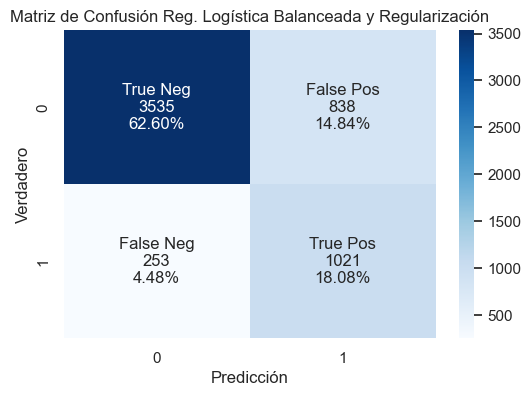

In [72]:
# Matriz de confusión con Heatmap.
labels = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_reg.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_reg.flatten()/np.sum(cf_matrix_reg)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6, 4))  
sns.heatmap(cf_matrix_reg, annot=labels, fmt="", cmap='Blues')

plt.title('Matriz de Confusión Reg. Logística Balanceada y Regularización', fontsize=12)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

##### Curva ROC y AUC 

In [73]:
# Obtengo las probabilidades de predicción del modelo
y_probs_reg= logistic_model_balanced_regul.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_re, tpr_re, thresholds_re = roc_curve(y_test_clean, y_probs_reg)
roc_auc_re = auc(fpr_re, tpr_re)

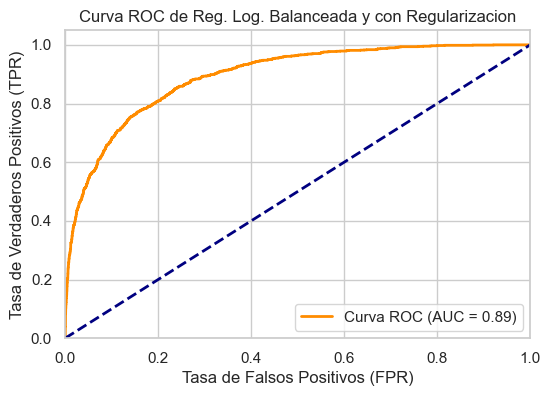

In [74]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_re, tpr_re, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_re)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Balanceada y con Regularizacion')
plt.legend(loc="lower right")
plt.show()

## Modelos Base (Ingenuos) 

### Modelo Base Naive Bayes.

El clasificador Naive Bayes se considera "ingenuo" debido a la suposición simplificada que hace sobre la independencia de las características. GaussianNB: para características numéricas continuas (como temperatura, humedad, etc.) que pueden seguir una distribución normal.

In [75]:
from sklearn.naive_bayes import GaussianNB

# Crear el clasificador Naive Bayes
naive_bayes_model = GaussianNB()

# Entrenar el modelo
naive_bayes_model.fit(x_train_clean, y_train_clean)

# Hacer predicciones en el conjunto de prueba
y_pred_nb = naive_bayes_model.predict(x_test_clean)


In [76]:
# Mostrar el reporte de clasificación
print("Resultados de Naive Bayes:\n")
print(classification_report(y_test_clean, y_pred_nb))

# Mostrar la matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_clean, y_pred_nb))


Resultados de Naive Bayes:

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4373
           1       0.56      0.68      0.62      1274

    accuracy                           0.81      5647
   macro avg       0.73      0.76      0.74      5647
weighted avg       0.82      0.81      0.81      5647

Matriz de Confusión:

[[3691  682]
 [ 404  870]]


In [85]:
# Calcular Balanced Accuracy
balanced_acc_nv= balanced_accuracy_score(y_test_clean, y_pred_nb)

print(f'Balanced Accuracy Naive Bayes: {balanced_acc_nv:.2f}')

Balanced Accuracy Naive Bayes: 0.76


In [77]:
# Obtengo las probabilidades de predicción del modelo
y_probs_nb = naive_bayes_model.predict_proba(x_test_clean)[:, 1]

# Calculo la ROC y el AUC
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test_clean, y_probs_nb)
roc_auc = auc(fpr_nb, tpr_nb)

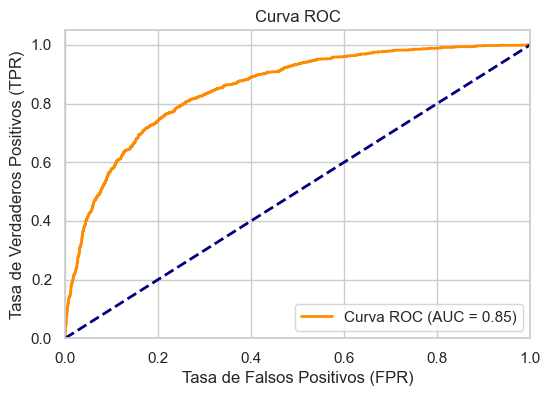

In [78]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Modelo Base: Moda.

Este modelo asigna la clase más frecuente en el conjunto de entrenamiento a todas las instancias en el conjunto de prueba.

In [79]:
# Calcular la moda
moda_result = mode(y_train_clean)
clase_mas_frecuente = moda_result.mode  # es un escalar

# Predecir usando la moda
y_pred_moda = [clase_mas_frecuente] * len(y_test_clean)

# Calcular la precisión
accuracy_moda = accuracy_score(y_test_clean, y_pred_moda)

print(f"Accuracy del modelo por moda: {accuracy_moda:.2f}")


Accuracy del modelo por moda: 0.77


In [80]:
# Mostrar el reporte de clasificación
print("Resultados de Baseline por Moda:\n")
print(classification_report(y_test_clean, y_pred_moda))

# Mostrar la matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_clean, y_pred_moda))

Resultados de Baseline por Moda:

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4373
           1       0.00      0.00      0.00      1274

    accuracy                           0.77      5647
   macro avg       0.39      0.50      0.44      5647
weighted avg       0.60      0.77      0.68      5647

Matriz de Confusión:

[[4373    0]
 [1274    0]]


In [86]:
# Calcular Balanced Accuracy
balanced_acc_moda= balanced_accuracy_score(y_test_clean, y_pred_moda)

print(f'Balanced Accuracy Moda: {balanced_acc_moda:.2f}')

Balanced Accuracy Moda: 0.50


Interpretacion:
4373: Verdaderos negativos (TN). Son los casos donde se predijo correctamente la clase negativa (que es la clase mayoritaria en tu dataset).

0: Falsos positivos (FP). No hay predicciones incorrectas de la clase positiva.

1274: Falsos negativos (FN). Estos son los casos donde la clase real es positiva, pero se predijo como negativa (la clase mayoritaria).

0: Verdaderos positivos (VP). No hay predicciones correctas para la clase 

La curva ROC no se puede calcular, ya que no es un modelo entrenado que devuelva probabilidades. Como se usa la moda para predecir, simplemente se asigna a todas las instancias el valor de la clase más frecuente.


## Comparación de Modelos

IndexError: list index out of range

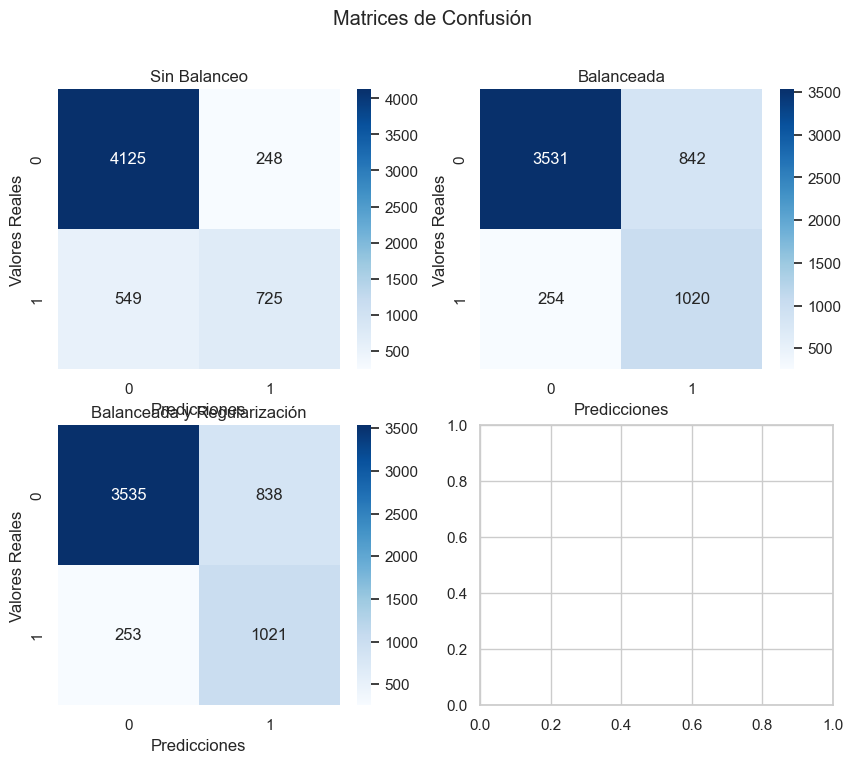

In [81]:
# Crea una figura con cuatro subgráficos
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Título para toda la figura
fig.suptitle("Matrices de Confusión")

# Títulos para cada subgráfico
titles = ["Sin Balanceo", "Balanceada", "Balanceada y Regularización"]

# Matrices de confusión
matrices = [cf_matrix, cf_matrix_b, cf_matrix_reg]

for i, ax in enumerate(axes.ravel()):
    sns.heatmap(matrices[i], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicciones")
    ax.set_ylabel("Valores Reales")
    ax.set_title(titles[i])

# Ajusta la disposición de los subgráficos
plt.tight_layout()
plt.show()

IndexError: list index out of range

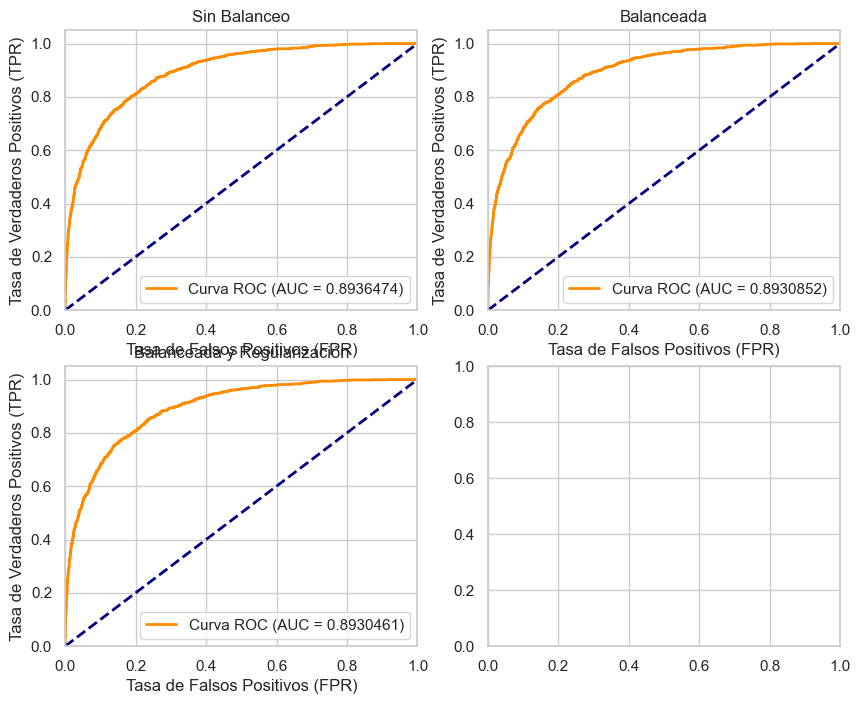

In [109]:
# Crear una figura con cuatro subgráficos
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Títulos para cada subgráfico
titles = ["Sin Balanceo", "Balanceada", "Balanceada y Regularización"]

# Probabilidades y etiquetas de prueba para cada modelo
y_probs_modelos = [y_probs_reglog, y_probs_balanced, y_probs_reg]

for i, ax in enumerate(axes.ravel()):
    fpr, tpr, thresholds = roc_curve(y_test_clean, y_probs_modelos[i])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.7f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos (FPR)')
    ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
    ax.set_title(titles[i])
    ax.legend(loc="lower right")

# Ajusta la disposición de los subgráficos
plt.tight_layout()
plt.show()

In [112]:
# Generar los informes de clasificación
report_reglog = classification_report(y_test_clean, y_pred, output_dict=True)
report_balanced = classification_report(y_test_clean, y_pred_balanced, output_dict=True)
report_regularized = classification_report(y_test_clean, y_pred_reg, output_dict=True)


In [113]:
# Extraer las métricas
metrics = {
    "Modelo": ["Regresión Logística", "Regres. Log. Balanceada", "Reg. Log. Balanc. Regularizada"],
    "Accuracy": [
        report_reglog["accuracy"],
        report_balanced["accuracy"],
        report_regularized["accuracy"]
    ],
    "Precision": [
        report_reglog["weighted avg"]["precision"],
        report_balanced["weighted avg"]["precision"],
        report_regularized["weighted avg"]["precision"]
    ],
    "Recall": [
        report_reglog["weighted avg"]["recall"],
        report_balanced["weighted avg"]["recall"],
        report_regularized["weighted avg"]["recall"]
    ],
    "F1 Score": [
        report_reglog["weighted avg"]["f1-score"],
        report_balanced["weighted avg"]["f1-score"],
        report_regularized["weighted avg"]["f1-score"]
    ]
}


In [114]:
# Crear el DataFrame Metricas
metrics_df = pd.DataFrame(metrics)

# Mostrar el DataFrame
print(metrics_df)


                           Modelo  Accuracy  Precision    Recall  F1 Score
0             Regresión Logística  0.807685   0.824462  0.807685  0.813988
1         Regres. Log. Balanceada  0.805915   0.846013  0.805915  0.817116
2  Reg. Log. Balanc. Regularizada  0.806800   0.846579  0.806800  0.817913


In [128]:
# Transformar el DataFrame para la visualización
metrics_melted = metrics_df.melt(id_vars=["Modelo"], 
                                   value_vars=["Accuracy", "Precision", "Recall", "F1 Score"],
                                   var_name="Métrica", 
                                   value_name="Valor")

# Crear el gráfico de barras
fig = px.bar(metrics_melted, 
             x='Modelo', 
             y='Valor', 
             color='Métrica', 
             barmode='group',
             title='Comparativa de Métricas por Modelo')

fig.show()


NameError: name 'px' is not defined